# Understanding consumer preferences for environmentally friendly products

### Introduction to Natural Language Processing at the University of Oxford: Python code for final paper

Megan Mantaro, 22 April 2022

## Introduction

This code applies topic modeling methods to reviews from Ni et al.'s (2019) Amazon review dataset to understand whether:
- Firm-initiated information sharing about products' environmental attributes influences customers' perceptions of the products (reviews of products with environmental messaging are more likely to mention green/ethical attributes in their reviews than reviewers of regular products)
- Other product characteristics (sensory, value, health, and delivery attributes) play a greater role in influencing consumer opinions than green/ethical attributes, both for products with environmental messaging/labeling and products without environmental messaging/labeling
- Perceived eco-friendliness will positively influence product ratings

Four product categories within Grocery & Gourmet Food are examined:
1. Tea
2. Coffee
3. Produce
4. Cooking Oils, Vinegars & Sprays

## Context and summary of findings

There is growing pressure for companies to add sustainable products to their offerings, but understanding how sustainable features influence customer perceptions and what drives customers to make more sustainable purchases is still a challenge. To date, most studies on sustainable consumer preferences for grocery products have used more traditional methods like surveys. However, natural language processing allows researchers to utilize large amounts of unstructured textual data to gain new insights into sustainability preferences. I analyse a total of 224,952 Amazon reviews across four grocery categories (tea; coffee; produce; and cooking oils, vinegars, and sprays) and perform a topic modelling analysis to extract the main topics expressed in reviews. A statistical analysis of the resulting topics reveals that reviewers of sustainable products are more likely to notice and comment on both environmental attributes and health attributes than reviewers of products with no mention of sustainability in their product descriptions. Overall, sustainability is much less important than taste to reviewers, but is on par with—or sometimes even more important than—other practical characteristics like value and delivery. Mentioning sustainable attributes in a review is associated with higher ratings for sustainable products—but not for non-sustainable products. These findings have implications for companies looking to develop and market sustainable grocery products, and highlight the usefulness of topic modelling for research on sustainable consumer preferences.

## Set up

### Modules & settings

In [1]:
# Import packages
import re
import string
import json
import pickle
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import nltk
import scipy.sparse as ss
import statsmodels.formula.api as smf

# Import functions
from html import unescape
from matplotlib import pyplot as plt
from collections import Counter
from scipy.spatial.distance import cosine
from sklearn.feature_extraction import _stop_words
from sklearn.model_selection import train_test_split
from corextopic import corextopic as ct
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from itertools import product
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest as ztest
from collections import defaultdict
from matplotlib.legend_handler import HandlerTuple

# Note: the following NLTK resources should be downloaded if not already
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

# Settings
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=FutureWarning)

### Functions

In [2]:
# Define function to compute cosine similarity
def cosine_sim(v_i, v_j):
    return 1 - cosine(v_i, v_j)

# Check number of reviews
def reviews_count(df, name):
    all_rev = len(df)
    env = len(df[df['environmental']==True])
    non_env = all_rev - env
    print(f"{name}: {env} ({env/all_rev*100:.1f}%) environmental reviews, {non_env} ({non_env/all_rev*100:.1f}%) other reviews ({all_rev} reviews in total)")
    
# Limit to nouns, adjectives, and adverbs
def pos_filter(tokenized_text):
    tagged = nltk.pos_tag(tokenized_text)
    filtered_text = [word for word, tag in tagged if tag.startswith(tuple(['N', 'J', 'RB']))]
    return filtered_text

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Review preprocessing steps:
# Removes HTML tags and non-letter characters, puts into lower case,
# removes stops, filters by POS, lemmatizes words
def text_processor(text):
    text = str(text)
    TAG_RE = re.compile(r'<[^>]+>')
    text = TAG_RE.sub('', text)
    text = unescape(text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text_list = [w for w in text.split() if w not in stops]
    text_list = pos_filter(text_list)
    text_list = [lemmatizer.lemmatize(word) for word in text_list]
    return ' '.join(text_list)

# Pipeline to clean dataframe
def clean_dataframe(df, name):
    print(f"{name} dataframe:")
    reviews_count(df, 'Initial review count')
    
    # Convert reviewTime to datetime format
    df['reviewTime'] = pd.to_datetime(df['reviewTime'], format='%m %d, %Y')

    # Limit to reviews after Nov 2013 (data goes until Oct 2018 so this will cover 5 years)
    df = df[df['reviewTime'] >= '2013-11-01']

    reviews_count(df, 'After removing reviews before Nov 2013')

    # Remove any NA reviews
    df = df[df['reviewText'].notna()]

    reviews_count(df, 'After removing N/A reviews')

    # Remove duplicates
    df.drop_duplicates(subset=['reviewText','asin','reviewerID'], inplace=True, ignore_index=True)

    reviews_count(df, 'After removing duplicate reviews')
    
    print()
    
    return df

def topic_processing(df):
    vect = CountVectorizer(binary=True, preprocessor=text_processor, ngram_range=(1,2),
                           max_df=.4, min_df=20)
    doc_word = vect.fit_transform(df['reviewText'])
    X = ss.csr_matrix(doc_word) # save as sparse matrix
    words = list(np.asarray(vect.get_feature_names_out())) # list of words in vocab
    

    return (vect, X, words)
    
# Assess CorEx number of topics
def hyperparameter_tuning_corex(cat_word_list, X, start=2, limit=21, step=1):
    # Set seed for reproducibility & to ensure models are equivalent
    seed = 123
    
    # Set anchor word options
    no_anchor_words = None
    base_anchor_words_only_env = [['environmentally','ethical','fair trade','fair','gmo','organic','certified','usda','environmental']]
    base_anchor_words_multiple_topics = [['environmentally','ethical','fair trade','fair','gmo','organic','certified','usda','environmental'],
                         ['health','benefit','healthy'],
                         ['flavor','taste'],
                         ['price','cost','worth'],
                         ['delivery','order','fast']]
    
    # Remove any words that aren't in the vocabulary of the review set
    base_anchor_words_only_env = [[word for word in topic if word in cat_word_list] for topic in base_anchor_words_only_env]
    base_anchor_words_multiple_topics = [[word for word in topic if word in cat_word_list] for topic in base_anchor_words_multiple_topics]

    # Set hyperparameters for tuning
    num_topics = range(start,limit,step)
    anchor_strength = [3,5,7,9]
    anchor_words = [no_anchor_words, base_anchor_words_only_env, base_anchor_words_multiple_topics]

    # Don't test multiple anchor strength options when not using anchor words
    all_params = list(product(anchor_words, anchor_strength))
    filtered_params = [[anchor_words, anchor_strength] for anchor_words, anchor_strength in all_params 
                       if not (anchor_words == None and anchor_strength in [5,7,9])] 
    
    # Fit topic model with different parameters & evaluate on coherence, homogeneity, TC
    coherence_scores = dict()
    tc_scores = dict()
    
    for anchor_words, anchor_strength in tqdm(filtered_params):
        if anchor_words == no_anchor_words:
            topic_name = "no anchor words"
        elif anchor_words == base_anchor_words_only_env:
            topic_name = f"env. anchor words only, strength {anchor_strength}"
        elif anchor_words == base_anchor_words_multiple_topics:
            topic_name = f"anchor words for multiple topics, strength {anchor_strength}"
        
        tc_scores[topic_name] = dict()
        
        for topic_n in num_topics: 
            if anchor_words==None or topic_n >= len(anchor_words):
                topic_model = ct.Corex(n_hidden=topic_n, seed=seed)
                topic_model.fit(X, words=cat_word_list, anchors=anchor_words, anchor_strength=anchor_strength)

                # Get total correlation (reported in nats)
                tc = topic_model.tc
                tc_scores[topic_name][topic_n] = tc
    
    return tc_scores
    
def plot_topics_from_dicts(ax, tcs, title, limit=21, step=2):
    colors = ['dimgray', 'lightcoral', 'indianred', 'firebrick', 'darkred', 'lightblue', 'lightskyblue', 'dodgerblue', 'mediumblue']
    
    # Plot total correlation
    for k, color, label in zip(tcs, colors, tcs.keys()):
        x = list(tcs[k].keys())
        ax.plot(x, tcs[k].values(), color=color, label=label)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Num Topics", fontsize=12)
    ax.set_ylabel("Total correlation (nats)", fontsize=12)
    ax.set_xlim(0, limit)
    ax.set_xticks(range(0, limit, step))
    ax.margins(0.1)
    
def get_print_topics(topic_model):
    topics = topic_model.get_topics()
    for topic_n,topic in enumerate(topics):
        # w: word, mi: mutual information, s: sign
        topic = [(w,mi,s) if s > 0 else ('~'+w,mi,s) for w,mi,s in topic]
        # Unpack the info about the topic
        words,mis,signs = zip(*topic)    
        # Print topic
        topic_str = str(topic_n+1)+': '+', '.join(words)
        print(topic_str)
        
    return topics

def process_test_data(test_df, vect, original_X):
    doc_word = vect.transform(test_df['reviewText'])
    test_X = ss.csr_matrix(doc_word)
    return test_X

def calculate_topic_prevalence(dfs, df_names, topic_col_name, topic_name):
    topic_prevalence = dict()
    for df, name in zip(dfs, df_names):
        env_prod_reviews = df[df['environmental']==True]
        nonenv_prod_reviews = df[df['environmental']==False]

        # Calculate share of reviews for env products that mention topic
        share_env_prod_w_topic = 100 * len(env_prod_reviews[env_prod_reviews[topic_col_name]==True]) / len(env_prod_reviews)
        
        # Calculate a 99% confidence interval for env products that mention topic
        ci_env_prod_w_topic = proportion_confint(count=len(env_prod_reviews[env_prod_reviews[topic_col_name]==True]),
                   nobs=len(env_prod_reviews),
                   alpha=(1 - 0.99))
        
        # Calculate share of reviews for non-env products that mention topic
        share_nonenv_prod_w_topic = 100 * len(nonenv_prod_reviews[nonenv_prod_reviews[topic_col_name]==True]) / len(nonenv_prod_reviews)
        
        # Calculate a 99% confidence interval for non-env products that mention env feature
        ci_nonenv_prod_w_topic = proportion_confint(count=len(nonenv_prod_reviews[nonenv_prod_reviews[topic_col_name]==True]),
                   nobs=len(nonenv_prod_reviews),
                   alpha=(1 - 0.99))
        
        # Chi-square test
        contigency = pd.crosstab(df['environmental'], df[topic_col_name])
        c, p, dof, expected = chi2_contingency(contigency) 
        
        topic_prevalence[name] = {'environmental products': f"{share_env_prod_w_topic:.2f}% ({ci_env_prod_w_topic[0]*100:.2f}-{ci_env_prod_w_topic[1]*100:.2f}%)", 
                                  'non-environmental products':f"{share_nonenv_prod_w_topic:.2f}% ({ci_nonenv_prod_w_topic[0]*100:.2f}-{ci_nonenv_prod_w_topic[1]*100:.2f}%)",
                                  'chi-square test':f"{c:.2f} ({p:.3f})"}

        
    
    df_topic_prevalence = pd.DataFrame(topic_prevalence).transpose()
    print(f"Prevalence of {topic_name} topic within product reviews")
    return df_topic_prevalence

### Load FastText embeddings and stop words

In [3]:
# Load fastText embeddings
with open('fasttext_vectors.p', 'rb') as f:
    fasttext_vecs = pickle.load(f)
    
# Load stopwords and add to list of stopwords (base on effect of cleaning function)
stops = list(_stop_words.ENGLISH_STOP_WORDS) + ['t', 's', 'm', 'll', 'don', 've', 'd',
                                                'didn','wasn','weren']

### Use FastText to identify word list for environmental label

In [4]:
# Create a list containing tuples of words and corresponding embeddings
vector_list = [(w, np.array(v)) for w, v in fasttext_vecs.items()]

# Initialize table as dictionary
table = dict()

targets = ['sustainability', 'sustainable', 'organic',
           'low-emission','low-carbon','recycled']

for w_i in targets:
    
    # Rank words according to cosine similarity
    nn_list = [w for w, v in sorted(vector_list, key=lambda x: cosine_sim(fasttext_vecs[w_i], x[1]), reverse=True)]
    
    # Compute 20 nearest neighbors (excluding word itself)
    table[w_i] = nn_list[1:21]
    
# Display table
pd.DataFrame.from_dict(table)

,sustainability,sustainable,organic,low-emission,low-carbon,recycled
0,sustainable,sustainability,organics,low-carbon,low-emission,non-recycled
1,environmental,resource-efficient,inorganic,high-emission,renewable,recycle
2,ecological,low-carbon,sustainable,renewable,resource-efficient,recycling
3,ecology,environmentally,unprocessed,energy-efficient,sustainable,reused
4,energy-efficiency,renewable,natural,energy-saving,high-emission,re-purposed
5,conservation,self-sustaining,carbon-based,non-fossil,non-fossil,repurposed
6,innovation,cost-efficient,synthetic,fuel-based,fuel-based,re-used
7,wellbeing,ecological,nitrogen-rich,low-emissivity,carbon,discarded
8,governance,equitable,carbon-bearing,sustainable,innovation-driven,reprocessed
9,initiatives,low-emission,foods,resource-efficient,carbon-based,reusing


In [5]:
# Identify relevant terms to check product description for
environmental_branding_terms = ['sustainable','sustainability','sustainably','eco-friendly',
                                'low-emission','low carbon','low-carbon','net zero carbon',
                                'organic','zero waste','carbon neutral','recycled',
                                'plastic-free','environmentally friendly','eco-conscious',
                                'biodegradable','compostable','renewable','100% natural',
                                'rainforest alliance','plant-based','vegan','fairtrade',
                                'fair trade','green certified','green-certified']

#NOTES: 
#(1) Environmental not included since it can be used in other contexts 
# (e.g. facial wash to remove environmental toxins)
#(2) Not all probe words (namely biodegradable, compostable, and the multi-word phrases)
# were available in the fastText word embeddings and thus couldn't be used to iteratively
# identify additional probe words
#(3) Final terms were chosen based on likelihood to be used in the right context
# within the product descriptions; words that denoted ethical considerations but 
# not environmental considerations (like 'community-driven') were not included due to
# the environmental focus of this paper

### Import reviews data

In [6]:
# Import k-core datasets for Grocery and Gourmet Food
grocery_gourmet_reviews = pd.read_json('Grocery_and_Gourmet_Food_5.json', lines=True)

# Get list of product ID's covered in datasets
grocery_gourmet_asin = grocery_gourmet_reviews['asin'].unique()

grocery_gourmet_reviews.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN
1,5,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN


In [7]:
# Keep only relevant columns
cols_to_keep = ['overall','verified','reviewTime','asin','reviewText','reviewerID']
grocery_gourmet_reviews = grocery_gourmet_reviews[cols_to_keep]
grocery_gourmet_reviews.rename(columns={'overall':'rating'}, inplace=True)
grocery_gourmet_reviews['reviewLength'] = grocery_gourmet_reviews['reviewText'].apply(lambda x: len(str(x).split()))

In [8]:
# Calculate average rating for each product
avg_ratings = grocery_gourmet_reviews.groupby('asin').mean()['rating']
avg_ratings = avg_ratings.rename('avgRating')

### Import product metadata

In [9]:
# Import metadata only for products included in review datasets
meta_grocery_gourmet = pd.read_json('meta_Grocery_and_Gourmet_Food.json', lines=True)
meta_grocery_gourmet = meta_grocery_gourmet[meta_grocery_gourmet['asin'].isin(grocery_gourmet_asin)]
meta_grocery_gourmet = meta_grocery_gourmet.merge(avg_ratings, on='asin')

In [10]:
meta_grocery_gourmet.head(1)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details,avgRating
0,"[Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Tea, Black]",,"[Lipton Yellow Label Tea use only the finest tea leaves. These leaves are specially cut to expose more of the juices, then they are curled into tiny beads to seal in more of the flavor. Enjoy a hot cup of Lipton Yellow Label Tea today., Tea, Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.]",,Lipton Yellow Label Tea (loose tea) - 450g,"[B00886E4K0, B00CREXSHY, B001QTRGAQ, B002EYZM4O, B000JSQK70, B00FMTETUQ, B001VIIXXQ, B002UP153Y, B07DZ4M75Z, B00N48M0OO, B000JSQDK4, B000JSQDGS, B00NMV6Y4A, B01HIKU16M, B002GWH78S, B002HQQZL8, B01KFFT910, B007ZI1SKG, 4639725183, B004XTDE1G, B01GFPS5XW, B004WB7G46, B000F4F94I, B000SARJF6, B003H7KV8Y, B0198R3EJY, B003XD73NS, B00FNND76S, B06XS3GLWH, B00136MKEO, B007ZI1UFY, B007A2QO3S, B00886GV06, B002HQEQQ4, B00KPT6JN8, B002Y1LCNM, B00PACC7B8, B003CIHTBU, B01LY2304D, B004TDRASO, B000EM6PC6, B0757QPXFR, B002L2MG5C, B000LRH6DQ, B000JSSNW0, B00JVAZ532, B01FV1XCIO, B010OP3Q92, B006E9QDXE, B004GCV9ZS, B000JSSNUC, B0011010XY, B00KKV77GE]",,Lipton,[],"30,937 in Grocery & Gourmet Food (","[B00CREXSHY, B001QTRGAQ, B000JSQK70, B002EYZM4O, B01282ULWY, B000JSQDGS, B00886E4K0, B002YJC990, B000JSQDK4, B001VIIXXQ, 4639725183, B007ZI1SKG, B002UP153Y, B007ZI1UFY, B00N48M0OO, B000EM6PC6, B000JSSNUC, B000HBIHLG, B00286KM8E, B000VDWJB4, B014GLC2LS, B00136MKEO, B006E9QDXE, B000MN630Q, B01HIKU16M, B01DTSTPDC, B004WB7G46, B01LOR5QV0, B01FV1XCIO, B00BOMGIBI, B003CJJLYW, B01LY2304D, B002GWH78S, B0748BNCCD, B000SATIFA, B01LOR5TYY, B000F4F94I, B00PACC7B8, B07FTWRGZ3, B00VFYPK82, B00C1ZQH86, B001QTN5ZG, B00YPICDXK, B00KPT6JN8, B004GCV9ZS, B0075NPAMS, B00FMGHMKI, B003H7KV8Y, B00G9NQXZS, B00XL1E6QO, B000NIHZMU, B003XD73NS, B008RYNJ9A]",Grocery,,,$12.46,4639725043,"[https://images-na.ssl-images-amazon.com/images/I/31V3NfjNACL._SS40_.jpg, https://images-na.ssl-images-amazon.com/images/I/51TS-bmrg0L._SS40_.jpg, https://images-na.ssl-images-amazon.com/images/I/21kL85tr17L._SS40_.jpg]","[https://images-na.ssl-images-amazon.com/images/I/31V3NfjNACL.jpg, https://images-na.ssl-images-amazon.com/images/I/51TS-bmrg0L.jpg, https://images-na.ssl-images-amazon.com/images/I/21kL85tr17L.jpg]",NaN,4.2


In [11]:
# Explode category lists and select desired categories
meta_grocery_exploded = meta_grocery_gourmet.explode('category')
selected_categories = ['Coffee','Tea','Produce','Cooking Oils, Vinegars & Sprays']
asin_cat_dict = dict()
all_asins = []
for category in selected_categories:
    asins = meta_grocery_exploded[meta_grocery_exploded['category']==category]['asin'].unique().tolist()
    asin_cat_dict[category] = asins
    all_asins += asins

# Limit to selected categories
meta_grocery_gourmet_subset = meta_grocery_exploded[meta_grocery_exploded['asin'].isin(all_asins)]

# Convert price column to float
meta_grocery_gourmet_subset['price'] = meta_grocery_gourmet_subset['price'].apply(lambda x: x[1:])
meta_grocery_gourmet_subset['price'] = pd.to_numeric(meta_grocery_gourmet_subset['price'], errors='coerce')

# Add column that tags product as eco-friendly based on product description
meta_grocery_gourmet_subset['description_lower'] = meta_grocery_gourmet_subset['description'].astype(str).str.lower()
regstring = '|'.join(environmental_branding_terms)
meta_grocery_gourmet_subset['environmental'] = meta_grocery_gourmet_subset['description_lower'].str.contains(regstring, na=False)

### Merge metadata with reviews and create sub-datasets for selected grocery categories

In [12]:
# Merge on ASIN
merged_grocery_gourmet = grocery_gourmet_reviews.merge(meta_grocery_gourmet_subset[['asin','environmental','title','price','avgRating']], 
                                                    on='asin',how='inner')

# Create sub-datasets
coffee_reviews = merged_grocery_gourmet[merged_grocery_gourmet['asin'].isin(asin_cat_dict['Coffee'])]
tea_reviews = merged_grocery_gourmet[merged_grocery_gourmet['asin'].isin(asin_cat_dict['Tea'])]
produce_reviews = merged_grocery_gourmet[merged_grocery_gourmet['asin'].isin(asin_cat_dict['Produce'])]
oils_vin_reviews = merged_grocery_gourmet[merged_grocery_gourmet['asin'].isin(asin_cat_dict['Cooking Oils, Vinegars & Sprays'])]

### Clean data

In [13]:
coffee_reviews = clean_dataframe(coffee_reviews, 'Coffee')
tea_reviews = clean_dataframe(tea_reviews, 'Tea')
produce_reviews = clean_dataframe(produce_reviews, 'Produce')
oils_vin_reviews = clean_dataframe(oils_vin_reviews, 'Cooking Oils, Vinegars & Sprays')

Coffee dataframe:
Initial review count: 93310 (15.7%) environmental reviews, 502383 (84.3%) other reviews (595693 reviews in total)
After removing reviews before Nov 2013: 75566 (15.2%) environmental reviews, 420115 (84.8%) other reviews (495681 reviews in total)
After removing N/A reviews: 75551 (15.2%) environmental reviews, 419980 (84.8%) other reviews (495531 reviews in total)
After removing duplicate reviews: 14657 (15.0%) environmental reviews, 82824 (85.0%) other reviews (97481 reviews in total)

Tea dataframe:
Initial review count: 178246 (33.7%) environmental reviews, 350145 (66.3%) other reviews (528391 reviews in total)
After removing reviews before Nov 2013: 151221 (33.9%) environmental reviews, 294697 (66.1%) other reviews (445918 reviews in total)
After removing N/A reviews: 151181 (33.9%) environmental reviews, 294623 (66.1%) other reviews (445804 reviews in total)
After removing duplicate reviews: 27952 (34.1%) environmental reviews, 53974 (65.9%) other reviews (81926 r

### Train test split

Use 60% of the data for training, 10% for topic model hyperparameter tuning, and 30% as holdout test data for hypothesis testing

In [14]:
# Coffee
coffee_train, coffee_val_test = train_test_split(coffee_reviews, 
                                                   test_size=0.4, 
                                                   stratify=coffee_reviews['environmental'], 
                                                   random_state=123)
coffee_val, coffee_test = train_test_split(coffee_val_test, 
                                             test_size=0.75, 
                                             stratify=coffee_val_test['environmental'], 
                                             random_state=123)

# Tea
tea_train, tea_val_test = train_test_split(tea_reviews, 
                                                   test_size=0.4, 
                                                   stratify=tea_reviews['environmental'], 
                                                   random_state=123)
tea_val, tea_test = train_test_split(tea_val_test, 
                                             test_size=0.75, 
                                             stratify=tea_val_test['environmental'], 
                                             random_state=123)



# Produce
produce_train, produce_val_test = train_test_split(produce_reviews, 
                                                   test_size=0.4, 
                                                   stratify=produce_reviews['environmental'], 
                                                   random_state=123)
produce_val, produce_test = train_test_split(produce_val_test, 
                                             test_size=0.75, 
                                             stratify=produce_val_test['environmental'], 
                                             random_state=123)

# Cooking Oils, Vinegars & Sprays
oils_vin_train, oils_vin_val_test = train_test_split(oils_vin_reviews, 
                                                   test_size=0.4, 
                                                   stratify=oils_vin_reviews['environmental'], 
                                                   random_state=123)
oils_vin_val, oils_vin_test = train_test_split(oils_vin_val_test, 
                                             test_size=0.75, 
                                             stratify=oils_vin_val_test['environmental'], 
                                             random_state=123)

## Topic models: Anchored CorEx

### Hyperparameter tuning

#### Tea

In [15]:
tea_val_vect, tea_val_X, tea_val_words = topic_processing(tea_val)

In [16]:
tea_tc_scores = hyperparameter_tuning_corex(tea_val_words, tea_val_X)

100%|██████████| 9/9 [04:28<00:00, 29.81s/it]


#### Coffee

In [17]:
coffee_val_vect, coffee_val_X, coffee_val_words = topic_processing(coffee_val)

In [18]:
coffee_tc_scores = hyperparameter_tuning_corex(coffee_val_words, coffee_val_X)

100%|██████████| 9/9 [05:05<00:00, 33.96s/it]


#### Produce

In [19]:
produce_val_vect, produce_val_X, produce_val_words = topic_processing(produce_val)

In [20]:
produce_tc_scores = hyperparameter_tuning_corex(produce_val_words, produce_val_X)

100%|██████████| 9/9 [01:32<00:00, 10.32s/it]


#### Oils & vinegar

In [21]:
oils_vin_val_vect, oils_vin_val_X, oils_vin_val_words = topic_processing(oils_vin_val)

In [22]:
oils_vin_tc_scores = hyperparameter_tuning_corex(oils_vin_val_words, oils_vin_val_X)

100%|██████████| 9/9 [01:33<00:00, 10.43s/it]


#### Plot

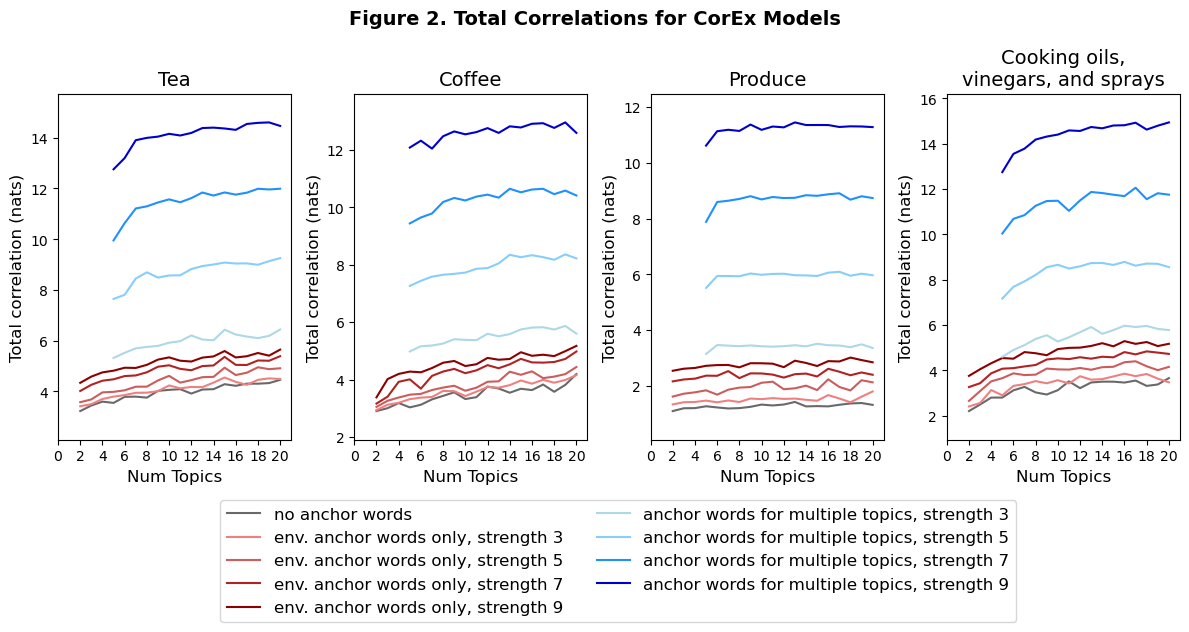

In [23]:
# Plot results of hyperparameter tuning
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,5))
plot_topics_from_dicts(ax1, tea_tc_scores, 'Tea')
plot_topics_from_dicts(ax2, coffee_tc_scores, 'Coffee')
plot_topics_from_dicts(ax3, produce_tc_scores, 'Produce')
plot_topics_from_dicts(ax4, oils_vin_tc_scores, 'Cooking oils,\nvinegars, and sprays')
plt.suptitle("Figure 2. Total Correlations for CorEx Models", fontsize=14, weight='bold')
fig.tight_layout()
ax4.legend(loc='center left', bbox_to_anchor=(-3.15, -.35), prop={'size': 12}, ncol=2)
plt.savefig("total_correlations.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Train topic models

In [24]:
base_anchor_words = [['environmentally','ethical','fair trade','fair','gmo','organic','certified','usda','environmental'],
                         ['health','benefit','healthy'],
                         ['flavor','taste'],
                         ['price','cost','worth'],
                         ['delivery','order','fast']]

#### Tea

In [25]:
# Set up
tea_vect, tea_X, tea_words = topic_processing(tea_train)
tea_anchor_words = [[word for word in topic if word in tea_words] for topic in base_anchor_words]

# Train the CorEx topic model
tea_topic_model = ct.Corex(n_hidden=7, seed=123)
tea_topic_model.fit(tea_X, words=tea_words, anchors=tea_anchor_words, anchor_strength=9)

# Examine topics
tea_topics = get_print_topics(tea_topic_model)

1: organic, fair, fair trade, gmo, usda, organic tea, tea organic, certified, organic green, organic matcha
2: health, benefit, healthy, health benefit, tea health, antioxidant, benefit green, healthy tea, benefit tea, good health
3: taste, flavor, tea taste, taste good, tea flavor, taste great, great taste, flavor tea, great flavor, taste tea
4: price, worth, cost, great price, good price, tea price, reasonable, reasonable price, price good, price great
5: order, fast, delivery, tea order, fast delivery, order tea, fast shipping, shipping, definitely order, product fast
6: green, review, little, milk, sugar, black, bit, really, green tea, honey
7: bag, water, cup, tea bag, just, time, use, leaf, hot, day


In [26]:
# Label topic groups ('topic_extra' means words in topic were not as strongly related)
tea_topic_names = ['topic_environmental','topic_health','topic_taste','topic_value',
                   'topic_delivery','topic_how_to_drink','topic_extra']

#### Coffee

In [27]:
# Set up
coffee_vect, coffee_X, coffee_words = topic_processing(coffee_train)
coffee_anchor_words = [[word for word in topic if word in coffee_words] for topic in base_anchor_words]

# Train the CorEx topic model
coffee_topic_model = ct.Corex(n_hidden=8, seed=123)
coffee_topic_model.fit(coffee_X, words=coffee_words, anchors=coffee_anchor_words, anchor_strength=9)

# Examine topics
coffee_topics = get_print_topics(coffee_topic_model)

1: organic, fair, fair trade, environmentally, organic coffee, usda, trade, gmo, environmental, coffee organic
2: bean, health, review, bag, water, really, benefit, healthy, sugar, little
3: flavor, taste, coffee taste, coffee flavor, great flavor, great taste, taste good, good flavor, taste great, flavor coffee
4: price, worth, cost, great price, good price, coffee price, reasonable, price good, reasonable price, price great
5: order, fast, delivery, coffee order, fast delivery, definitely order, order coffee, time order, order time, fast shipping
6: roast, dark, medium, dark roast, french, medium roast, roast coffee, mountain, french roast, light
7: cup, cup coffee, morning, brand, day, blend, time, year, amazon, rich
8: just, keurig, machine, ground, use, pack, different, box, pod, variety


In [28]:
# Label topic groups ('topic_extra' means words in topic were not as strongly related)
coffee_topic_names = ['topic_environmental','topic_extra','topic_taste','topic_value',
                      'topic_delivery','topic_roast_type','topic_extra2','topic_making_coffee']

#### Produce

In [29]:
# Set up
produce_vect, produce_X, produce_words = topic_processing(produce_train)
produce_anchor_words = [[word for word in topic if word in produce_words] for topic in base_anchor_words]

# Train the CorEx topic model
produce_topic_model = ct.Corex(n_hidden=9, seed=123)
produce_topic_model.fit(produce_X, words=produce_words, anchors=produce_anchor_words, anchor_strength=9)

# Examine topics
produce_topics = get_print_topics(produce_topic_model)

1: organic, fair, gmo, usda, non, organic goji, non gmo, non organic, pesticide, chemical
2: healthy, health, benefit, healthy snack, health benefit, health food, great healthy, food store, good healthy, delicious healthy
3: taste, flavor, taste great, taste good, great taste, texture, good taste, great flavor, good flavor, taste fresh
4: price, worth, cost, great price, good price, reasonable, worth price, price good, price great, reasonable price
5: order, fast, delivery, definitely order, good order, product fast, fast shipping, second order, fresh order, shipping
6: just, fruit, sugar, sweet, dried, eat, right, really, little, tart
7: bag, review, brand, hard, amazon, bit, date, package, dry, piece
8: store, time, grocery, grocery store, long, use, year, water, food, day
9: berry, great, goji, goji berry, great product, product, quality, mix, value, snack


In [30]:
# Label topic groups
produce_topic_names = ['topic_environmental','topic_health','topic_taste','topic_value',
                       'topic_delivery','topic_dried_fruit','topic_packaging','topic_source',
                       'topic_berries_snacks']

#### Oils & vinegar

In [31]:
# Set up
oils_vin_vect, oils_vin_X, oils_vin_words = topic_processing(oils_vin_train)
oils_vin_anchor_words = [[word for word in topic if word in oils_vin_words] for topic in base_anchor_words]

# Train the CorEx topic model
oils_vin_topic_model = ct.Corex(n_hidden=8, seed=123)
oils_vin_topic_model.fit(oils_vin_X, words=oils_vin_words, anchors=oils_vin_anchor_words, anchor_strength=9)

# Examine topics
oils_vin_topics = get_print_topics(oils_vin_topic_model)

1: organic, gmo, fair, usda, organic coconut, organic extra, non gmo, non, oil organic, organic virgin
2: health, healthy, benefit, health benefit, oil health, healthy oil, benefit coconut, benefit oil, healthy fat, oil healthy
3: taste, flavor, taste good, taste great, coconut flavor, oil taste, great taste, taste coconut, great flavor, coconut taste
4: price, worth, cost, great price, good price, reasonable, price great, oil price, best price, price good
5: order, fast, delivery, fast delivery, product fast, shipping, service, oil usually, quick, continue
6: oil, olive, olive oil, virgin, extra, extra virgin, high, salad, avocado oil, avocado
7: coconut, coconut oil, skin, use, hair, jar, butter, moisturizer, use coconut, body
8: just, bottle, little, brand, review, store, way, year, apple, long


In [32]:
# Label topic groups ('topic_extra' means words in topic were not as strongly related)
oils_vin_topic_names = ['topic_environmental','topic_health','topic_taste','topic_value',
                        'topic_delivery','topic_cooking_salad_oil','topic_coconut_oil',
                        'topic_extra']

### Get topic scores for train datasets

In [33]:
# TOPIC SCORES FOR TRAIN DATA

# Get topic scores & labels for tea
tea_train_labels = pd.DataFrame(tea_topic_model.labels, columns=['pred_' + name for name in tea_topic_names])
tea_train_p_y_given_x = pd.DataFrame(tea_topic_model.p_y_given_x, columns=['proba_' + name for name in tea_topic_names])
tea_train_w_topics = tea_train.reset_index().join(tea_train_labels).join(tea_train_p_y_given_x)

# Get topic scores & labels for coffee
coffee_train_labels = pd.DataFrame(coffee_topic_model.labels, columns=['pred_' + name for name in coffee_topic_names])
coffee_train_p_y_given_x = pd.DataFrame(coffee_topic_model.p_y_given_x, columns=['proba_' + name for name in coffee_topic_names])
coffee_train_w_topics = coffee_train.reset_index().join(coffee_train_labels).join(coffee_train_p_y_given_x)

# Get topic scores & labels for produce
produce_train_labels = pd.DataFrame(produce_topic_model.labels, columns=['pred_' + name for name in produce_topic_names])
produce_train_p_y_given_x = pd.DataFrame(produce_topic_model.p_y_given_x, columns=['proba_' + name for name in produce_topic_names])
produce_train_w_topics = produce_train.reset_index().join(produce_train_labels).join(produce_train_p_y_given_x)

# Get topic scores & labels for oils_vin
oils_vin_train_labels = pd.DataFrame(oils_vin_topic_model.labels, columns=['pred_' + name for name in oils_vin_topic_names])
oils_vin_train_p_y_given_x = pd.DataFrame(oils_vin_topic_model.p_y_given_x, columns=['proba_' + name for name in oils_vin_topic_names])
oils_vin_train_w_topics = oils_vin_train.reset_index().join(oils_vin_train_labels).join(oils_vin_train_p_y_given_x)

### Apply topic models to test data

In [34]:
# Get sparse matrices for test reviews
oils_vin_test_X = process_test_data(oils_vin_test, oils_vin_vect, oils_vin_X)
produce_test_X = process_test_data(produce_test, produce_vect, produce_X)
tea_test_X = process_test_data(tea_test, tea_vect, tea_X)
coffee_test_X = process_test_data(coffee_test, coffee_vect, coffee_X)

In [35]:
# TOPIC SCORES FOR TEST DATA
# Collect the topic probabilities and predictions for all categories

# Get topic scores & labels for tea
tea_p_y_given_x = pd.DataFrame(tea_topic_model.predict_proba(tea_test_X)[0], columns=['proba_' + name for name in tea_topic_names])
tea_labels = pd.DataFrame(tea_topic_model.predict(tea_test_X), columns=['pred_' + name for name in tea_topic_names])
tea_test_w_topics = tea_test.reset_index().join(tea_labels).join(tea_p_y_given_x)

# Get topic scores & labels for coffee
coffee_p_y_given_x = pd.DataFrame(coffee_topic_model.predict_proba(coffee_test_X)[0], columns=['proba_' + name for name in coffee_topic_names])
coffee_labels = pd.DataFrame(coffee_topic_model.predict(coffee_test_X), columns=['pred_' + name for name in coffee_topic_names])
coffee_test_w_topics = coffee_test.reset_index().join(coffee_labels).join(coffee_p_y_given_x)

# Get topic scores & labels for produce
produce_p_y_given_x = pd.DataFrame(produce_topic_model.predict_proba(produce_test_X)[0], columns=['proba_' + name for name in produce_topic_names])
produce_labels = pd.DataFrame(produce_topic_model.predict(produce_test_X), columns=['pred_' + name for name in produce_topic_names])
produce_test_w_topics = produce_test.reset_index().join(produce_labels).join(produce_p_y_given_x)

# Get topic scores & labels for oils_vin
oils_vin_p_y_given_x = pd.DataFrame(oils_vin_topic_model.predict_proba(oils_vin_test_X)[0], columns=['proba_' + name for name in oils_vin_topic_names])
oils_vin_labels = pd.DataFrame(oils_vin_topic_model.predict(oils_vin_test_X), columns=['pred_' + name for name in oils_vin_topic_names])
oils_vin_test_w_topics = oils_vin_test.reset_index().join(oils_vin_labels).join(oils_vin_p_y_given_x)

## Descriptive statistics

In [36]:
coffee_asins = list(coffee_reviews['asin'].unique())
tea_asins = list(tea_reviews['asin'].unique())
produce_asins = list(produce_reviews['asin'].unique())
oils_vin_asins = list(oils_vin_reviews['asin'].unique())

asins = [coffee_asins, tea_asins, produce_asins, oils_vin_asins]

### Tables

In [37]:
# Product-level descriptive statistics
tea_asins = list(tea_reviews['asin'].unique())
coffee_asins = list(coffee_reviews['asin'].unique())
produce_asins = list(produce_reviews['asin'].unique())
oils_vin_asins = list(oils_vin_reviews['asin'].unique())

asins = [tea_asins, coffee_asins, produce_asins, oils_vin_asins]
names = ['Tea','Coffee','Produce','Cooking oils, vinegars & sprays']
describe_cols = ['avgRating','price']

desc_dict_prod = dict()
for name, asin_filter in zip(names, asins):
    df = meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(asin_filter)]
    desc_dict_prod[name] = df[describe_cols].describe().round(2)
    
print("Product-level data")
pd.concat(desc_dict_prod.values(), axis=1, keys=desc_dict_prod.keys())

Product-level data


Tea              Coffee             Produce           \
      avgRating     price avgRating     price avgRating    price   
count  16232.00  10482.00  16706.00  10775.00   4503.00  1960.00   
mean       4.44     17.41      4.38     27.00      4.24    23.90   
std        0.40     11.77      0.41     16.21      0.50    53.54   
min        2.12      1.99      1.35      1.90      2.00     0.80   
25%        4.22      9.08      4.18     14.99      4.00    11.95   
50%        4.50     14.23      4.43     23.00      4.33    16.49   
75%        4.73     22.00      4.67     34.99      4.60    25.99   
max        5.00    125.11      5.00    142.00      5.00   999.00   

      Cooking oils, vinegars & sprays           
                            avgRating    price  
count                         3992.00  2645.00  
mean                             4.56    22.18  
std                              0.36    15.45  
min                              2.20     4.21  
25%                              4.40    11.90  
50%                              4.62    17.99  
75%                              4.81    27.80  
max                              5.00   112.50

In [38]:
# Review-level descriptive statistics

describe_cols = ['rating','reviewLength','verified']

tea_desc = tea_train_w_topics[describe_cols].describe(include=['bool', 'int64', 'float64']).round(2)
coffee_desc = coffee_train_w_topics[describe_cols].describe(include=['bool', 'int64', 'float64']).round(2)
produce_desc = produce_train_w_topics[describe_cols].describe(include=['bool', 'int64', 'float64']).round(2)
oils_vin_desc = oils_vin_train_w_topics[describe_cols].describe(include=['bool', 'int64', 'float64']).round(2)

desc_dict = {'Tea' : tea_desc, 
     'Coffee' : coffee_desc, 
     'Produce' : produce_desc, 
     'Cooking oils, vinegars & sprays' : oils_vin_desc}
print("Review-level data")
pd.concat(desc_dict.values(), axis=1, keys=desc_dict.keys())

Review-level data


Tea                          Coffee                        \
          rating reviewLength verified    rating reviewLength verified   
count   49155.00     49155.00    49155  58488.00     58488.00    58488   
unique       NaN          NaN        2       NaN          NaN        2   
top          NaN          NaN     True       NaN          NaN     True   
freq         NaN          NaN    43893       NaN          NaN    53201   
mean        4.51        36.67      NaN      4.42        29.56      NaN   
std         1.00        60.32      NaN      1.05        47.70      NaN   
min         1.00         1.00      NaN      1.00         1.00      NaN   
25%         4.00         7.00      NaN      4.00         5.00      NaN   
50%         5.00        19.00      NaN      5.00        14.00      NaN   
75%         5.00        42.00      NaN      5.00        34.00      NaN   
max         5.00      2088.00      NaN      5.00      1163.00      NaN   

         Produce                       Cooking oils, vinegars & sprays  \
          rating reviewLength verified                          rating   
count   13874.00     13874.00    13874                        13452.00   
unique       NaN          NaN        2                             NaN   
top          NaN          NaN     True                             NaN   
freq         NaN          NaN    12297                             NaN   
mean        4.30        27.42      NaN                            4.63   
std         1.21        41.87      NaN                            0.88   
min         1.00         1.00      NaN                            1.00   
25%         4.00         5.00      NaN                            5.00   
50%         5.00        14.00      NaN                            5.00   
75%         5.00        33.00      NaN                            5.00   
max         5.00       878.00      NaN                            5.00   

                              
       reviewLength verified  
count      13452.00    13452  
unique          NaN        2  
top             NaN     True  
freq            NaN    12026  
mean          38.82      NaN  
std           70.86      NaN  
min            1.00      NaN  
25%            6.00      NaN  
50%           18.00      NaN  
75%           43.00      NaN  
max         1954.00      NaN

### Missing data

In [39]:
# Review-level missing data
missing_dict = {'Tea':tea_train_w_topics.isna().sum(),
                'Coffee':coffee_train_w_topics.isna().sum(),
                'Produce':produce_train_w_topics.isna().sum(),
                'Cooking oils, vinegars & sprays':oils_vin_train_w_topics.isna().sum()}
print("Review level missing data")
pd.DataFrame(missing_dict)

Review level missing data


,Tea,Coffee,Produce,"Cooking oils, vinegars & sprays"
asin,0.0,0.0,0.0,0.0
avgRating,0.0,0.0,0.0,0.0
environmental,0.0,0.0,0.0,0.0
index,0.0,0.0,0.0,0.0
pred_topic_berries_snacks,NaN,NaN,0.0,NaN
pred_topic_coconut_oil,NaN,NaN,NaN,0.0
pred_topic_cooking_salad_oil,NaN,NaN,NaN,0.0
pred_topic_delivery,0.0,0.0,0.0,0.0
pred_topic_dried_fruit,NaN,NaN,0.0,NaN
pred_topic_environmental,0.0,0.0,0.0,0.0


In [40]:
# Product-level missing data
missing_dict = {'Tea':meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(tea_asins)].isna().sum(),
                'Coffee':meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(coffee_asins)].isna().sum(),
                'Produce':meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(produce_asins)].isna().sum(),
                'Cooking oils, vinegars & sprays':meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(oils_vin_asins)].isna().sum()}
print("Product level missing data")
pd.DataFrame(missing_dict)

Product level missing data


,Tea,Coffee,Produce,"Cooking oils, vinegars & sprays"
category,0,0,0,0
tech1,0,0,0,0
description,0,0,0,0
fit,0,0,0,0
title,0,0,0,0
also_buy,0,0,0,0
tech2,0,0,0,0
brand,0,0,0,0
feature,0,0,0,0
rank,0,0,0,0


In [41]:
# Product-level missing data
missing_dict = {'Tea':meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(tea_asins)].isna().mean()*100,
                'Coffee':meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(coffee_asins)].isna().mean()*100,
                'Produce':meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(produce_asins)].isna().mean()*100,
                'Cooking oils, vinegars & sprays':meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(oils_vin_asins)].isna().mean()*100}
print("Missing data for price (%)")
pd.DataFrame(missing_dict).loc['price'].round(1)

Missing data for price (%)


Tea                                35.4
Coffee                             35.5
Produce                            56.5
Cooking oils, vinegars & sprays    33.7
Name: price, dtype: float64

### Examine price outliers

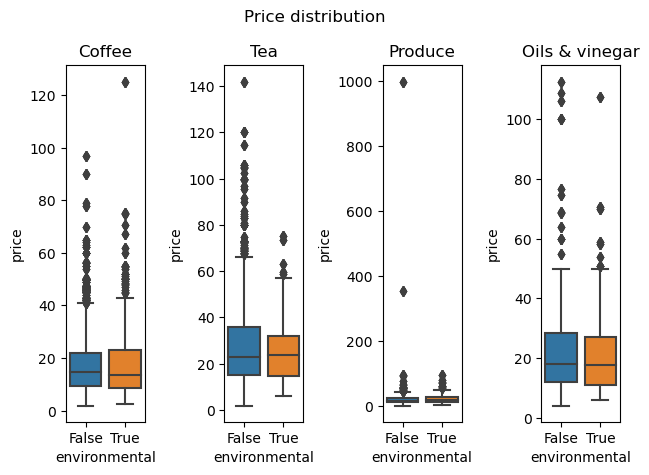

In [42]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1,4)
axes = [ax1, ax2, ax3, ax4]
names = ['Coffee', 'Tea', 'Produce', 'Oils & vinegar']

for ax, asin_filter, name in zip(axes, asins, names):
    sns.boxplot(x='environmental', y='price', data=meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(asin_filter)], ax=ax)
    ax.set_title(name)
    
plt.suptitle('Price distribution')
fig.tight_layout()
plt.show()

In [43]:
outlier_cutoffs = {'tea':meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(tea_asins)]['price'].quantile(0.999),
                   'coffee':meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(coffee_asins)]['price'].quantile(0.999),
                   'produce':meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(produce_asins)]['price'].quantile(0.999),
                   'oils_vin':meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(oils_vin_asins)]['price'].quantile(0.999)}

def get_category(asin):
    if asin in tea_asins:
        return 'tea'
    elif asin in coffee_asins:
        return 'coffee'
    elif asin in produce_asins:
        return 'produce'
    elif asin in oils_vin_asins:
        return 'oils_vin'
    else:
        return None
    
meta_grocery_gourmet_subset['category'] = meta_grocery_gourmet_subset['asin'].apply(get_category)
meta_grocery_gourmet_subset = meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['category'].notna()]


In [44]:
missing_before = meta_grocery_gourmet_subset['price'].isna().sum()
meta_grocery_gourmet_subset['trimmed_price'] = meta_grocery_gourmet_subset.apply(lambda x: x['price'] if x['price'] < outlier_cutoffs[x['category']] else None, axis=1)
missing_after = meta_grocery_gourmet_subset['trimmed_price'].isna().sum()
print(f"{missing_after - missing_before} outliers removed")


40 outliers removed


In [45]:
# Product-level descriptive table incl. trimmed price
names = ['Tea','Coffee','Produce','Cooking oils, vinegars & sprays']
describe_cols = ['avgRating','price','trimmed_price']

desc_dict_prod = dict()
for name, asin_filter in zip(names, asins):
    df = meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(asin_filter)]
    desc_dict_prod[name] = df[describe_cols].describe().round(2)
    
print("Product-level data")
pd.concat(desc_dict_prod.values(), axis=1, keys=desc_dict_prod.keys())

Product-level data


Tea                            Coffee                          \
      avgRating     price trimmed_price avgRating     price trimmed_price   
count  16232.00  10482.00      10467.00  16706.00  10775.00      10760.00   
mean       4.44     17.41         17.28      4.38     27.00         26.86   
std        0.40     11.77         11.30      0.41     16.21         15.78   
min        2.12      1.99          1.99      1.35      1.90          1.90   
25%        4.22      9.08          9.07      4.18     14.99         14.99   
50%        4.50     14.23         14.20      4.43     23.00         22.99   
75%        4.73     22.00         21.99      4.67     34.99         34.99   
max        5.00    125.11         78.90      5.00    142.00        114.72   

        Produce                        Cooking oils, vinegars & sprays  \
      avgRating    price trimmed_price                       avgRating   
count   4503.00  1960.00       1955.00                         3992.00   
mean       4.24    23.90         21.41                            4.56   
std        0.50    53.54         20.86                            0.36   
min        2.00     0.80          0.80                            2.20   
25%        4.00    11.95         11.95                            4.40   
50%        4.33    16.49         16.24                            4.62   
75%        4.60    25.99         25.54                            4.81   
max        5.00   999.00        354.95                            5.00   

                              
         price trimmed_price  
count  2645.00       2640.00  
mean     22.18         22.01  
std      15.45         14.96  
min       4.21          4.21  
25%      11.90         11.90  
50%      17.99         17.99  
75%      27.80         27.78  
max     112.50        108.58

### Plots

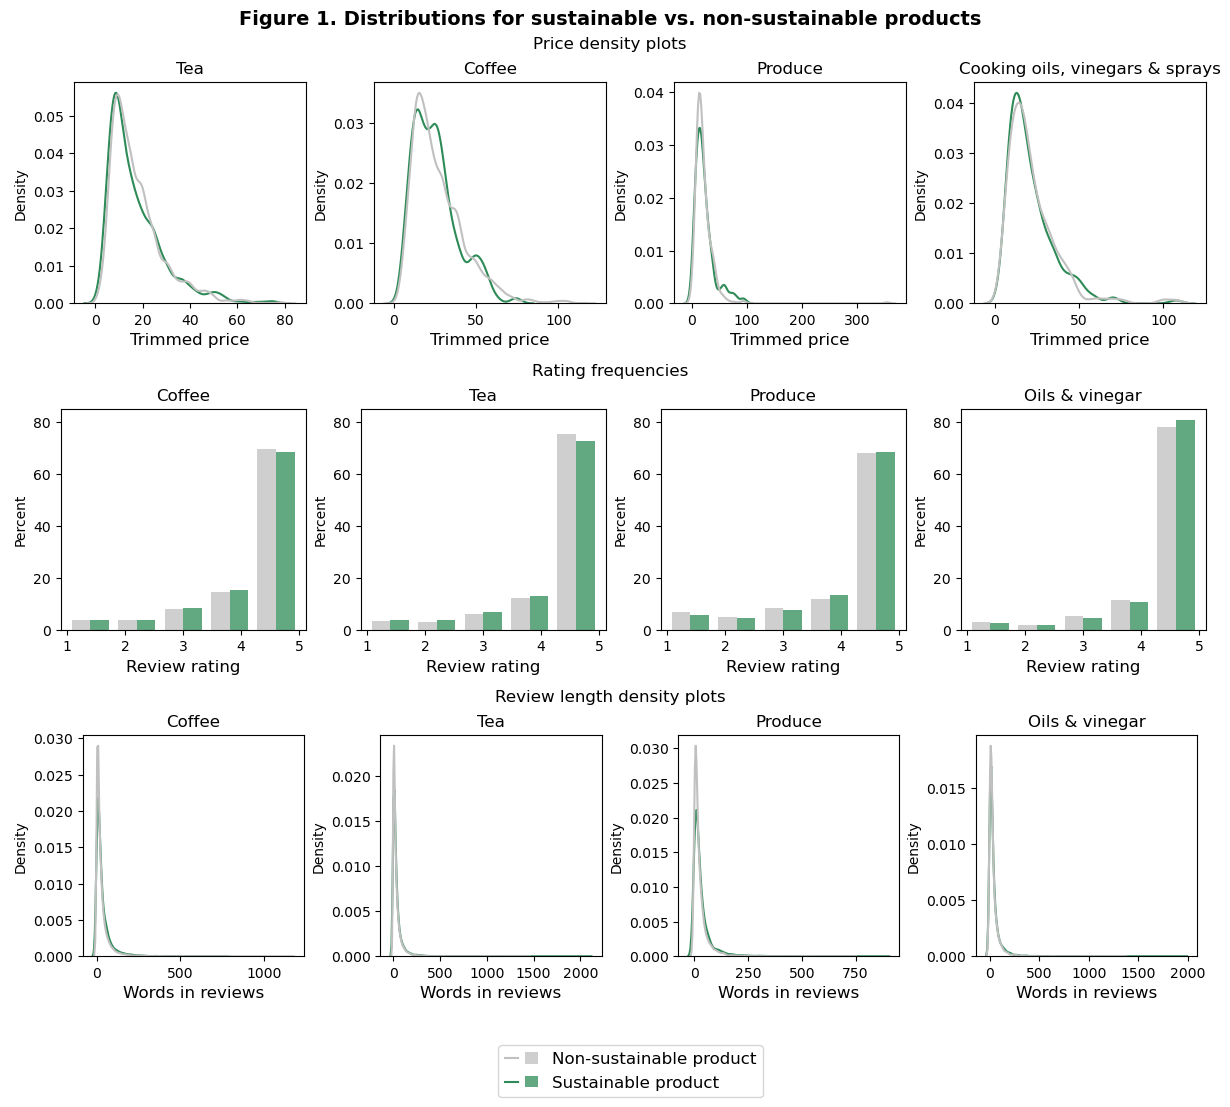

In [46]:
fig = plt.figure(constrained_layout=True, figsize=(12,10))

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)

# Price
subfigs[0].suptitle('Price density plots',fontsize=12)
axs = subfigs[0].subplots(nrows=1, ncols=4)
for asin_filter, ax, name in zip(asins, axs, names):
    sns.kdeplot(data=meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['asin'].isin(asin_filter)].reset_index(), 
                x="trimmed_price", hue="environmental", ax=ax, common_norm=False, palette=['silver','seagreen'])
    # h,l = ax.get_legend_handles_labels()
    # ax.legend(handles=h, labels=l, title='Sustainable product')
    ax.set_title(name)
    ax.set_xlabel('Trimmed price',fontsize=12)
    ax.get_legend().set_visible(False)
    h1 = ax.get_legend().legendHandles

# Rating
subfigs[1].suptitle('Rating frequencies',fontsize=12)
axs = subfigs[1].subplots(nrows=1, ncols=4)
dfs = [coffee_train_w_topics, tea_train_w_topics, produce_train_w_topics, oils_vin_train_w_topics]
names = ['Coffee', 'Tea', 'Produce', 'Oils & vinegar']
for ax, df, name in zip(axs, dfs, names):
    sns.histplot(df, x="rating", hue='environmental', multiple="dodge", stat='percent', 
                 common_norm=False, ax=ax, bins=5, shrink=.8, palette=['silver','seagreen'], linewidth=0)
    # h,l = ax.get_legend_handles_labels()
    # ax.legend(handles=h, labels=l, title='Sustainable product')
    ax.set_title(name)
    ax.set_ylim(0,85)
    ax.set_xlabel('Review rating',fontsize=12)
    ax.get_legend().set_visible(False)
    h2 = ax.get_legend().legendHandles
    
# Review length
subfigs[2].suptitle('Review length density plots',fontsize=12)
axs = subfigs[2].subplots(nrows=1, ncols=4)
for ax, df, name in zip(axs, dfs, names):
    sns.kdeplot(data=df, x="reviewLength", ax=ax, hue='environmental', common_norm=False, palette=['silver','seagreen'])
    # h,l = ax.get_legend_handles_labels()
    # ax.legend(handles=h, labels=l, title='Sustainable product')
    ax.set_title(name)
    ax.set_xlabel('Words in reviews',fontsize=12)
    ax.get_legend().set_visible(False)
    h3 = ax.get_legend().legendHandles

# Create a single legend
handles = h1 + h2
labels = ['Non-sustainable product', 'Sustainable product']*2
label_dict = defaultdict(list)
for label, handle in zip(labels, handles):
    label_dict[label].append(handle)
combined_labels = label_dict.keys()
tup_handles = [tuple(x) for x in label_dict.values()]
fig.legend(tup_handles, combined_labels,
           handler_map={tuple: HandlerTuple(ndivide=None)},loc='lower left',
           bbox_to_anchor=(.4,-.1),fontsize=12)

fig.suptitle('Figure 1. Distributions for sustainable vs. non-sustainable products', 
             fontsize=14, weight='bold')
plt.savefig("desc_stats.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Hypothesis testing

### Prevalence of topics (with 99% confidence interval)

The following code calculates the prevalence of the environmental, taste, value, delivery, and health topics for reviews of sustainable products and non-sustainable products, respectively. Chi-square tests are used to determine whether occurrence of the environmental topic is independent of the type of product.

In [47]:
dfs = [tea_test_w_topics, coffee_test_w_topics, produce_test_w_topics, oils_vin_test_w_topics]
df_names = ['Tea test', 'Coffee test', 'Produce test', 'Oils & vinegar test']
dfs_excl_coffee = [tea_test_w_topics, produce_test_w_topics, oils_vin_test_w_topics]
df_names_excl_coffee = ['Tea test', 'Produce test', 'Oils & vinegar test']

In [48]:
# Prevalance of environmental topic
env_topic_prev = calculate_topic_prevalence(dfs, df_names, 'pred_topic_environmental', 'environmental')
display(env_topic_prev)

Prevalence of environmental topic within product reviews


,environmental products,non-environmental products,chi-square test
Tea test,7.31% (6.58-8.04%),2.26% (1.96-2.56%),367.03 (0.000)
Coffee test,8.80% (7.70-9.90%),1.68% (1.47-1.89%),704.70 (0.000)
Produce test,9.22% (7.56-10.87%),3.04% (2.40-3.67%),117.69 (0.000)
Oils & vinegar test,8.99% (7.82-10.16%),2.88% (2.06-3.70%),99.06 (0.000)


In [49]:
# Prevalance of taste topic
taste_topic_prev = calculate_topic_prevalence(dfs, df_names, 'pred_topic_taste', 'taste')
display(taste_topic_prev)

Prevalence of taste topic within product reviews


,environmental products,non-environmental products,chi-square test
Tea test,39.41% (38.04-40.79%),36.16% (35.19-37.13%),24.87 (0.000)
Coffee test,36.30% (34.43-38.17%),34.00% (33.23-34.78%),8.62 (0.003)
Produce test,23.76% (21.32-26.19%),16.68% (15.31-18.05%),46.66 (0.000)
Oils & vinegar test,25.52% (23.74-27.30%),31.86% (29.57-34.15%),32.04 (0.000)


In [50]:
# Prevalance of value topic
value_topic_prev = calculate_topic_prevalence(dfs, df_names, 'pred_topic_value', 'value')
display(value_topic_prev)

Prevalence of value topic within product reviews


,environmental products,non-environmental products,chi-square test
Tea test,9.44% (8.62-10.27%),8.10% (7.55-8.65%),12.54 (0.000)
Coffee test,11.53% (10.29-12.77%),11.23% (10.72-11.75%),0.30 (0.582)
Produce test,9.96% (8.24-11.67%),7.27% (6.32-8.23%),13.59 (0.000)
Oils & vinegar test,11.53% (10.23-12.83%),12.71% (11.07-14.35%),2.03 (0.154)


In [51]:
# Prevalance of delivery topic
delivery_topic_prev = calculate_topic_prevalence(dfs, df_names, 'pred_topic_delivery', 'delivery')
display(delivery_topic_prev)

Prevalence of delivery topic within product reviews


,environmental products,non-environmental products,chi-square test
Tea test,4.13% (3.57-4.69%),4.37% (3.95-4.78%),0.72 (0.396)
Coffee test,5.69% (4.79-6.59%),5.60% (5.23-5.98%),0.03 (0.852)
Produce test,5.32% (4.04-6.61%),6.23% (5.34-7.12%),1.96 (0.161)
Oils & vinegar test,4.35% (3.51-5.18%),4.70% (3.66-5.74%),0.39 (0.532)


In [52]:
# Prevalance of health topic (coffee reviews did not have this topic & were not included)
health_topic_prev = calculate_topic_prevalence(dfs_excl_coffee, df_names_excl_coffee, 'pred_topic_health', 'health')
display(health_topic_prev)

Prevalence of health topic within product reviews


,environmental products,non-environmental products,chi-square test
Tea test,5.93% (5.26-6.59%),2.92% (2.58-3.26%),130.86 (0.000)
Produce test,9.71% (8.02-11.40%),3.40% (2.74-4.07%),113.62 (0.000)
Oils & vinegar test,9.52% (8.32-10.72%),5.28% (4.18-6.38%),40.08 (0.000)


### Z-test for topic prevalence

The following code tests whether prevalence of the environmental topic is significantly different (i.e. whether the environmental topic is more or less common) than other topics.

In [53]:
# Two sample z-tests for environmental products to see if there is a difference in topic prevalence
topic_wise_ztest = dict()

for topic in ['pred_topic_taste','pred_topic_value','pred_topic_delivery','pred_topic_health']:
    topic_wise_ztest[topic] = dict()
    for df, name in zip(dfs, ['tea','coffee','produce','oils & vinegar']):
        if name=='coffee' and topic=='pred_topic_health':
            pass
        else:
            z, p = ztest(df[df['environmental']==True]['pred_topic_environmental'], 
                         df[df['environmental']==True][topic], value=0)
            topic_wise_ztest[topic][name] = f"{z:.2f} ({p:.3f})"
        
topic_wise_ztest_df = pd.DataFrame(topic_wise_ztest)
display(topic_wise_ztest_df)

,pred_topic_taste,pred_topic_value,pred_topic_delivery,pred_topic_health
tea,-53.09 (0.000),-4.99 (0.000),8.90 (0.000),3.60 (0.000)
coffee,-32.66 (0.000),-4.24 (0.000),5.65 (0.000),NaN
produce,-12.72 (0.000),-0.80 (0.424),4.79 (0.000),-0.54 (0.592)
oils & vinegar,-20.00 (0.000),-3.73 (0.000),8.35 (0.000),-0.81 (0.417)


In [54]:
# Two sample z-tests for non-environmental products to see if there is a difference in topic prevalence
topic_wise_ztest = dict()

for topic in ['pred_topic_taste','pred_topic_value','pred_topic_delivery','pred_topic_health']:
    topic_wise_ztest[topic] = dict()
    for df, name in zip(dfs, ['tea','coffee','produce','oils & vinegar']):
        if name=='coffee' and topic=='pred_topic_health':
            pass
        else:
            z, p = ztest(df[df['environmental']==False]['pred_topic_environmental'], 
                         df[df['environmental']==False][topic], value=0)
            topic_wise_ztest[topic][name] = f"{z:.2f} ({p:.3f})"
        
topic_wise_ztest_df = pd.DataFrame(topic_wise_ztest)
display(topic_wise_ztest_df)

,pred_topic_taste,pred_topic_value,pred_topic_delivery,pred_topic_health
tea,-85.77 (0.000),-23.92 (0.000),-10.60 (0.000),-3.74 (0.000)
coffee,-103.79 (0.000),-44.15 (0.000),-23.45 (0.000),NaN
produce,-23.30 (0.000),-9.54 (0.000),-7.56 (0.000),-1.03 (0.303)
oils & vinegar,-30.68 (0.000),-13.82 (0.000),-3.54 (0.000),-4.51 (0.000)


### Plot topic prevalence

In [55]:
tea_test_w_topics['category'] = 'Tea'
coffee_test_w_topics['category'] = 'Coffee'
produce_test_w_topics['category'] = 'Produce'
oils_vin_test_w_topics['category'] = 'Cooking\noils, vinegars,\n& sprays'

dfs = [tea_test_w_topics, coffee_test_w_topics, produce_test_w_topics, oils_vin_test_w_topics]
all_test_data = pd.concat(dfs)

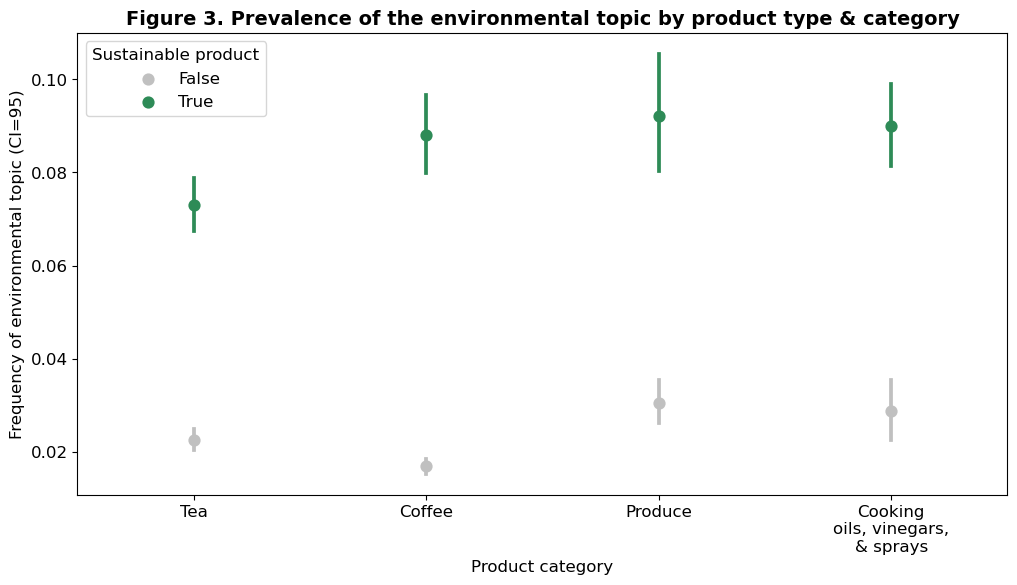

In [56]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
sns.pointplot(x="category", y="pred_topic_environmental", hue="environmental", data=all_test_data, 
              ci=95, join=False, palette=['silver','seagreen'], linewidth=.5)
plt.xlabel('Product category', fontsize=12)
plt.ylabel('Frequency of environmental topic (CI=95)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Sustainable product', fontsize=12, title_fontsize=12)
plt.title('Figure 3. Prevalence of the environmental topic by product type & category', 
          fontsize=14, weight='bold')
plt.savefig("env_topic.pdf", format='pdf', bbox_inches='tight')
plt.show()

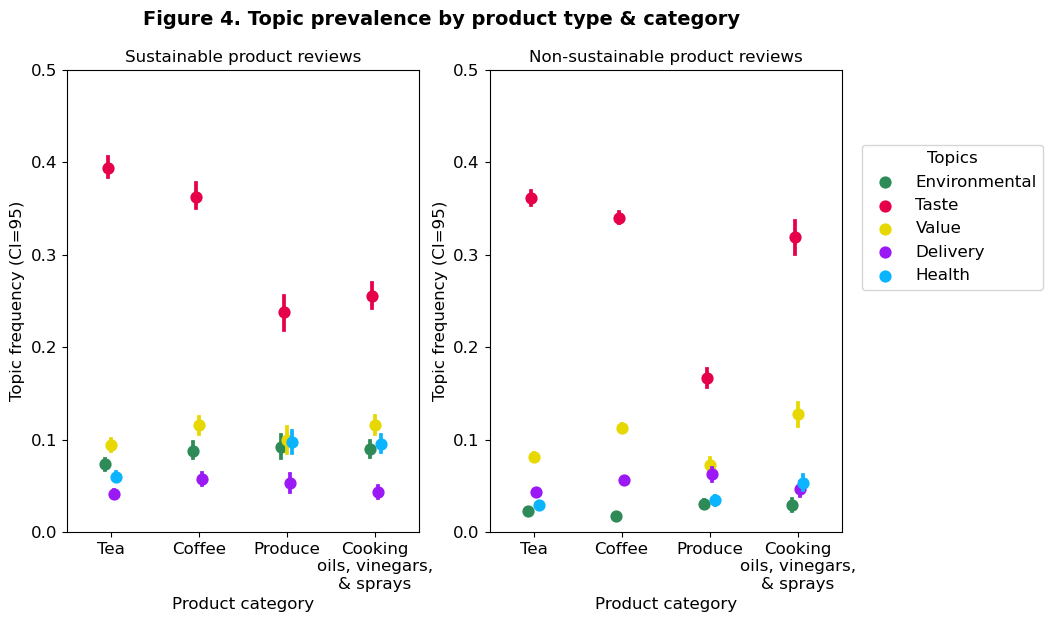

In [57]:
palette = ['seagreen','#e60049','#e6d800','#9b19f5','#0bb4ff']

all_test_data_melted = pd.melt(all_test_data, id_vars=['index','environmental','category'], 
                               value_vars=['pred_topic_environmental','pred_topic_taste',
                                           'pred_topic_value','pred_topic_delivery','pred_topic_health'], 
                               var_name='topic', value_name='topic_prevalence')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))

sns.pointplot(x="category", y="topic_prevalence", hue="topic", 
              data=all_test_data_melted[all_test_data_melted['environmental']==True], 
              ci=95, join=False, ax=ax1, palette=palette, dodge=True)

ax1.set_xlabel('Product category', fontsize=12)
ax1.set_ylabel('Topic frequency (CI=95)', fontsize=12)
ax1.set_title('Sustainable product reviews', fontsize=12)
ax1.set_ylim(0, 0.5)
ax1.tick_params(labelsize=12)
ax1.get_legend().remove()

sns.pointplot(x="category", y="topic_prevalence", hue="topic", 
              data=all_test_data_melted[all_test_data_melted['environmental']==False], 
              ci=95, join=False, ax=ax2, palette=palette, dodge=True)

ax2.set_xlabel('Product category', fontsize=12)
ax2.set_ylabel('Topic frequency (CI=95)', fontsize=12)
ax2.set_title('Non-sustainable product reviews', fontsize=12)
ax2.set_ylim(0, 0.5)
ax2.tick_params(labelsize=12)
topic_to_name = {'pred_topic_environmental':'Environmental',
                 'pred_topic_taste':'Taste',
                 'pred_topic_value':'Value',
                 'pred_topic_delivery':'Delivery',
                 'pred_topic_health':'Health'}
h,l = ax2.get_legend_handles_labels()
fig.legend(handles=h, labels=[topic_to_name[label] for label in l], loc='lower right', 
           title='Topics',bbox_to_anchor=(1.11,0.5), title_fontsize=12, fontsize=12, bbox_transform=fig.transFigure)
ax2.get_legend().remove()

plt.suptitle('Figure 4. Topic prevalence by product type & category', fontsize=14, weight='bold')
plt.savefig("all_topics.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Correlation matrices

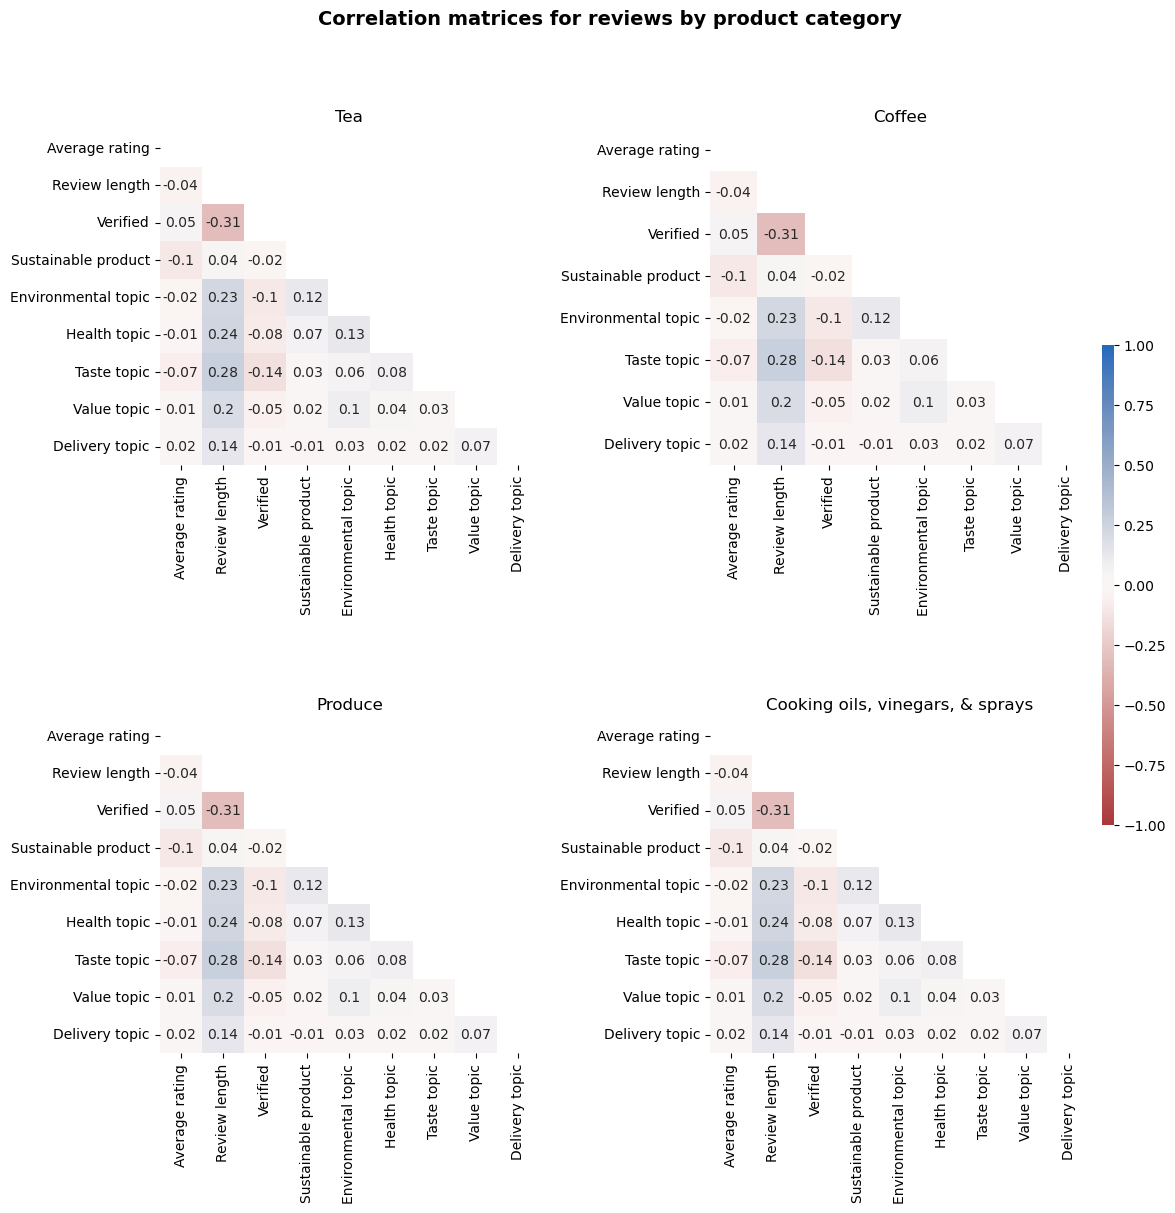

In [58]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,12))
cbar_ax = fig.add_axes([.91, .3, .01, .4])
dfs = [tea_test_w_topics, coffee_test_w_topics, produce_test_w_topics, oils_vin_test_w_topics]
axes = [ax1, ax2, ax3, ax4]
names = ['Tea','Coffee','Produce','Cooking oils, vinegars, & sprays']

for i, (df, ax, name) in enumerate(zip(dfs, axes, names)):
    if i == 1: # Coffee does not have health topic
        cols = ['avgRating','reviewLength','verified','environmental',
                'proba_topic_environmental','proba_topic_taste',
                'proba_topic_value','proba_topic_delivery']
        labels = ['Average rating','Review length','Verified',
                  'Sustainable product','Environmental topic',
                  'Taste topic','Value topic',
                  'Delivery topic']
    else:
        cols = ['avgRating','reviewLength','verified','environmental',
                'proba_topic_environmental','proba_topic_health',
                'proba_topic_taste','proba_topic_value','proba_topic_delivery']
        labels = ['Average rating','Review length','Verified',
                  'Sustainable product','Environmental topic',
                  'Health topic','Taste topic',
                  'Value topic','Delivery topic']
    corr_matrix = tea_test_w_topics[cols].corr().round(2)
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_matrix, yticklabels=labels, xticklabels=labels, annot=True, mask=mask, 
                vmin=-1, vmax=1, center=0, cmap='vlag_r', ax=ax, cbar_ax=cbar_ax)
    ax.set_title(name)
    
plt.suptitle('Correlation matrices for reviews by product category',fontsize=14,weight='bold')
plt.subplots_adjust(hspace=.75,wspace=.45)
plt.savefig("corr_matrices.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Regression model

#### Tea

In [59]:
form = 'rating ~ avgRating + proba_topic_environmental + proba_topic_health + proba_topic_taste + proba_topic_value + proba_topic_delivery + environmental + verified + proba_topic_environmental*environmental' 
fit = smf.ols(formula = form, data = tea_test_w_topics).fit(cov_type='HC1')
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     183.5
Date:                Thu, 21 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:10:20   Log-Likelihood:                -33621.
No. Observations:               24579   AIC:                         6.726e+04
Df Residuals:                   24569   BIC:                         6.734e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           0.2549      0.131      1.943      0.052      -0.002       0.512
environmental[T.True]                              -0.0251      0.014     -1.832      0.067      -0.052       0.002
verified[T.True]                                    0.1142      0.022      5.114      0.000       0.070       0.158
avgRating                                           0.9433      0.028     33.372      0.000       0.888       0.999
proba_topic_environmental                          -0.1004      0.056     -1.796      0.073      -0.210       0.009
proba_topic_environmental:environmental[T.True]     0.1928      0.067      2.885      0.004       0.062       0.324
proba_topic_health                                  0.0972      0.031      3.141      0.002       0.037       0.158
proba_topic_taste                                  -0.2396      0.014    -17.663      0.000      -0.266      -0.213
proba_topic_value                                   0.0604      0.020      2.980      0.003       0.021       0.100
proba_topic_delivery                                0.0396      0.029      1.369      0.171      -0.017       0.096
==============================================================================
Omnibus:                     9457.701   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31933.096
Skew:                          -2.003   Prob(JB):                         0.00
Kurtosis:                       6.890   Cond. No.                         84.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

#### Coffee

In [60]:
form = 'rating ~ avgRating + proba_topic_environmental + proba_topic_taste + proba_topic_value + proba_topic_delivery + environmental + verified + proba_topic_environmental*environmental'
fit = smf.ols(formula = form, data = coffee_test_w_topics).fit(cov_type='HC1')
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     238.2
Date:                Thu, 21 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:10:21   Log-Likelihood:                -41458.
No. Observations:               29245   AIC:                         8.293e+04
Df Residuals:                   29236   BIC:                         8.301e+04
Df Model:                           8                                         
Covariance Type:                  HC1                                         
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           0.3183      0.111      2.865      0.004       0.101       0.536
environmental[T.True]                              -0.0122      0.017     -0.701      0.483      -0.046       0.022
verified[T.True]                                    0.1367      0.024      5.720      0.000       0.090       0.184
avgRating                                           0.9170      0.025     37.221      0.000       0.869       0.965
proba_topic_environmental                          -0.0568      0.053     -1.065      0.287      -0.161       0.048
proba_topic_environmental:environmental[T.True]     0.1776      0.075      2.380      0.017       0.031       0.324
proba_topic_taste                                  -0.2071      0.013    -15.706      0.000      -0.233      -0.181
proba_topic_value                                   0.0939      0.017      5.502      0.000       0.060       0.127
proba_topic_delivery                                0.0468      0.026      1.828      0.068      -0.003       0.097
==============================================================================
Omnibus:                     9293.177   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24209.727
Skew:                          -1.755   Prob(JB):                         0.00
Kurtosis:                       5.748   Cond. No.                         76.3
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

#### Produce

In [61]:
form = 'rating ~ avgRating + proba_topic_environmental + proba_topic_health + proba_topic_taste + proba_topic_value + proba_topic_delivery + environmental + verified + proba_topic_environmental*environmental' 
fit = smf.ols(formula = form, data = produce_test_w_topics).fit(cov_type='HC1')
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     67.03
Date:                Thu, 21 Apr 2022   Prob (F-statistic):          7.77e-119
Time:                        11:10:21   Log-Likelihood:                -10732.
No. Observations:                6938   AIC:                         2.148e+04
Df Residuals:                    6928   BIC:                         2.155e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           0.1575      0.189      0.834      0.404      -0.212       0.528
environmental[T.True]                               0.0421      0.030      1.391      0.164      -0.017       0.101
verified[T.True]                                    0.1159      0.047      2.473      0.013       0.024       0.208
avgRating                                           0.9473      0.042     22.509      0.000       0.865       1.030
proba_topic_environmental                          -0.2618      0.112     -2.341      0.019      -0.481      -0.043
proba_topic_environmental:environmental[T.True]     0.3891      0.133      2.925      0.003       0.128       0.650
proba_topic_health                                  0.1581      0.055      2.873      0.004       0.050       0.266
proba_topic_taste                                  -0.2240      0.037     -6.137      0.000      -0.296      -0.152
proba_topic_value                                   0.1372      0.042      3.255      0.001       0.055       0.220
proba_topic_delivery                               -0.0358      0.059     -0.606      0.545      -0.152       0.080
==============================================================================
Omnibus:                     1653.251   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3195.466
Skew:                          -1.473   Prob(JB):                         0.00
Kurtosis:                       4.542   Cond. No.                         53.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

#### Cooking oils, vinegars, and sprays

In [62]:
form = 'rating ~ avgRating + proba_topic_environmental + proba_topic_health + proba_topic_taste + proba_topic_value + proba_topic_delivery + environmental + verified + proba_topic_environmental*environmental'
fit = smf.ols(formula = form, data = oils_vin_test_w_topics).fit(cov_type='HC1')
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     33.05
Date:                Thu, 21 Apr 2022   Prob (F-statistic):           1.93e-57
Time:                        11:10:21   Log-Likelihood:                -8393.8
No. Observations:                6727   AIC:                         1.681e+04
Df Residuals:                    6717   BIC:                         1.688e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -0.2199      0.301     -0.730      0.466      -0.810       0.371
environmental[T.True]                              -0.0149      0.021     -0.695      0.487      -0.057       0.027
verified[T.True]                                    0.0674      0.038      1.753      0.080      -0.008       0.143
avgRating                                           1.0404      0.064     16.308      0.000       0.915       1.165
proba_topic_environmental                          -0.2505      0.119     -2.108      0.035      -0.483      -0.018
proba_topic_environmental:environmental[T.True]     0.2294      0.129      1.778      0.075      -0.023       0.482
proba_topic_health                                  0.0942      0.035      2.662      0.008       0.025       0.164
proba_topic_taste                                  -0.0638      0.025     -2.589      0.010      -0.112      -0.016
proba_topic_value                                  -0.0148      0.031     -0.480      0.631      -0.075       0.046
proba_topic_delivery                                0.0168      0.050      0.334      0.738      -0.082       0.115
==============================================================================
Omnibus:                     3288.823   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17207.221
Skew:                          -2.388   Prob(JB):                         0.00
Kurtosis:                       9.211   Cond. No.                         96.3
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

## Sample product description and reviews

In [63]:
# Print sample environmental product descriptions
display(meta_grocery_gourmet_subset[meta_grocery_gourmet_subset['environmental']==True][['title','description']].sample(n=3, random_state=3))


,title,description
10772,"La Tourangelle Infused White Truffle Oil, 8.45 Ounce Tin","[La Tourangelle White Truffle Flavored Oil begins with expeller-pressed Organic Sunflower Oil, which is slowly infused with white truffle flavor following a150-year-old French tradition., This product is produce in a plant that processes tree nuts, and may contain trace amounts of tree nuts, sesame seeds and milk protein., organic sunflower oil, White Truffle Aroma., Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.]"
23034,LAVAZZA ESPRESSO DELICATO 72 PACKS made for KEURIG RIVO SYSTEM,"[RIVO ESPRESSO. Crafted by Lavazza just for the Keurig Rivo System. This blend is a medium roast, ground espresso that is Rain Forest Alliance Certified.\nPleasant aroma with balanced acidity. Slightly sweet with notes of chocolate and a long lasting citrus finish. 100% sustainably grown coffee, Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.]"
41135,"Green Mountain Coffee Organic Ethiopia Yirgacheffe Keurig K-Cups, 16 Count","[Grown on farms we've worked with for over 10 years, Green Mountain Coffee Ethiopia Yirgacheffe (pronounced yer-guh-chef [with a hard ""ch""]) has a sweet, floral aroma and delicate hints of spice. In the cup, you'll experience clear notes of citrus and ginger together with crisp acidity for a coffee that is a cheerful escape from the everyday. Long before you've taken your first sip, we've been finding and roasting the highest quality coffee in the world while building good relationships with the farmers who grow it. This commitment is best reflected in our Organic line of coffees. Fair Trade CertifiedTM and carefully sourced, these distinctive single-origin varieties and the artful blends are sustainably grown and intricately cared for. It's a pure and exceptionally delicious difference you can experience in every cup. Includes 16 K-Cups. PLEASE NOTE THE PACKAGING CHANGE: DUE TO A RECENT PACKAGING CHANGE, THE GRAPHICAL DESIGN OF THE K-CUP BOXES & LIDS MAY VARY SLIGHTLY FROM IMAGE. THE PRODUCT INGREDIENTS, ROAST, AMOUNT OF GRINDS, ETC. HAVE NOT CHANGED AND ARE EXACTLY THE SAME AS THIS PRODUCT HAS ALWAYS BEEN., Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.]"


In [64]:
# Sample reviews with environmental topic
sample_reviews = all_test_data[all_test_data['pred_topic_environmental']==True][['title','reviewText','pred_topic_taste',
                                                                'pred_topic_value','pred_topic_delivery',
                                                                'pred_topic_health','pred_topic_roast_type',
                                                                'pred_topic_making_coffee','pred_topic_how_to_drink',
                                                                'pred_topic_cooking_salad_oil',
                                                                'pred_topic_coconut_oil','pred_topic_dried_fruit',
                                                                'pred_topic_packaging','pred_topic_source',
                                                                'pred_topic_berries_snacks']].sample(3, random_state=1)
sample_reviews

,title,reviewText,pred_topic_taste,pred_topic_value,pred_topic_delivery,pred_topic_health,pred_topic_roast_type,pred_topic_making_coffee,pred_topic_how_to_drink,pred_topic_cooking_salad_oil,pred_topic_coconut_oil,pred_topic_dried_fruit,pred_topic_packaging,pred_topic_source,pred_topic_berries_snacks
16310,USDA Organic Coffee Beans Non-GMO &amp; Fair Trade - 2lb - Cafe Contibio - 100% Arabica Specialty Gourmet Grade - Delicious Light Medium Roast (32 OZ),"This coffee has a really good flavor. It's not too strong and not too weak. I really don't know how to describe it, but it smells amazingly fresh, 'and my favorite thing is that it is organic! Good brand and I was very lucky to purchase it with a discount!",True,False,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14569,"Taylors of Harrogate Classic Tea Variety Gift Box, 48 Count","My partner and I received this TAYLORS OF HARROGATE CLASSIC TEA VARIETY BOX for our anniversary, and we are more than pleased. There are eight varieties in the box -- English Breakfast, Earl Grey, Decaffeinated Breakfast, Lemon & Orange, Pure Assam, Green Tea with Jasmine, Organic Peppermint, and Organic Chamomile -- and six of each, yielding 48 teabags. You can't go wrong with Taylors. Even the box is a treat: staid on the outside, colorful and helpful on the inside, all cardboard (no wasted wood) and cello-wrapped. Would make a great gift under a variety of circumstances. Thank you, H.B.!",False,False,False,False,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
2052,Eden Foods Organic Brown Rice Vinegar -- 10 fl oz,"Im on my second bottle of Eden Foods Organic Brown Rice Vinegar. The flavor is mild and does not overpower our sushi rolls. Being organic is a plus, too. I will continue buying this brand in the future.",True,False,False,False,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN
